# Example training run

In this notebook, we will run a simple training run of `eqx-llama` on the `TinyStories` dataset. We will use utf-8 codepoints as tokens for simplicity.


## Constants

Let's set a few constants and hyper parameters.

In [1]:
batch_size = 10
max_seq_len = 1_000  # See below why we choose this value
seed = 0
learning_rate = 3e-4
weight_decay = 0.1
evaluate_each = 10

## Environment variables

We set helpful environment variables:
- `XLA_PYTHON_CLIENT_PREALLOCATE=false` prevents Jax from grabbing 75% of the GPU memory at once (useful to debug OOM).
- `--xla_gpu_deterministic_ops=true` ensures XLA uses deterministic operations, which in turns makes the training runs reproducible.

In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_FLAGS"] = "--xla_gpu_deterministic_ops=true"
os.environ["JAX_TRACEBACK_FILTERING"] = "off"

## Data loading

We will use tiny stories from the huggingface hub.

In [3]:
from datasets import load_dataset

ds = load_dataset(
    "roneneldan/TinyStories",
    trust_remote_code=False,
    streaming=True,
    download_mode="force_redownload",
)

# Let's vizualize a few examples to make sure everything's alright.
for example, i in zip(ds["train"], range(1, 3)):
    print(f"*** Example {i}")
    print(example["text"])
    print("***\n")

*** Example 1
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."

Together, they shared the needle and sewed the button on Lily's shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.
***

*** Example 2
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.

One day, Beep was driving in the park when he saw a big tree. The tree had

Let's look at the data: what is an appropriate sequence length to use for training? From the histogram below, 1000 seems like a reasonable value; it leaves us with a lot of examples to learn from. We will filter out examples that are longer and pad those that are shorter.

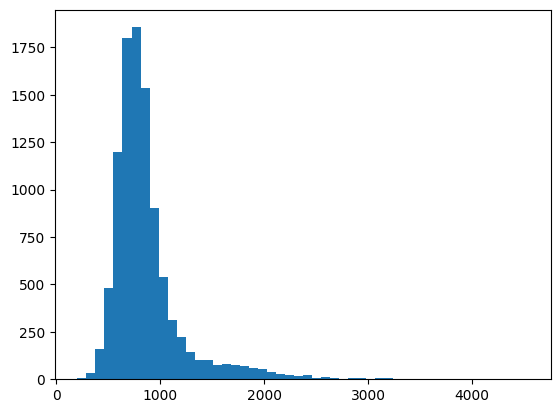

In [4]:
import matplotlib.pyplot as plt

lens = []
for example, i in zip(ds["train"], range(10_000)):
    lens.append(len(example["text"].encode("utf-8")))

plt.hist(lens, bins=50)
plt.show()

For this example, using the datasets without extra dataloading is enough.

In [5]:
import numpy as np


def prepare_example(inputs):
    batch = np.zeros((batch_size, max_seq_len), dtype=int)
    for i, s in enumerate(inputs):
        batch[i, : len(s)] = s
    return batch


ds_train = (
    ds["train"]
    .map(lambda ex: {"input": list(ex["text"].encode("utf-8"))})
    .map(lambda ex: {"len": len(ex["input"])})
    .filter(lambda ex: ex["len"] <= max_seq_len)
    .shuffle(seed=seed)
    .batch(batch_size, drop_last_batch=True)
    .map(
        lambda ex: ex
        | {
            "input": prepare_example(ex["input"]),
            "len": np.array(ex["len"], dtype=int),
        }
    )
)

ds_validation = (
    ds["validation"]
    .map(lambda ex: {"input": list(ex["text"].encode("utf-8"))})
    .map(lambda ex: {"len": len(ex["input"])})
    .filter(lambda ex: len(ex["input"]) <= max_seq_len)
    .shuffle(seed=seed)
    .batch(batch_size, drop_last_batch=True)
    .map(
        lambda ex: ex
        | {
            "input": prepare_example(ex["input"]),
            "len": np.array(ex["len"], dtype=int),
        }
    )
    .repeat(2)
)

## Model

Let's prepare the model! 🦙

In [6]:
# A bunch of imports for what follows

import math

import equinox as eqx
import jax
import jax.numpy as jnp

from eqx_llama import KVCache, LLaMA, LLaMAConfig

In [7]:
key = jax.random.PRNGKey(seed)
key, key_model = jax.random.split(key)

config = LLaMAConfig(
    num_layers=8,
    vocab_size=256,  # As we use utf-8 codepoints
    layer_dim=128,
    attention_num_heads=8,
    attention_head_dim=16,
    feed_forward_dim=512,
)
model = LLaMA(config=config, key=key_model, dtype="bfloat16")
cache = KVCache()


Let's count the params for our language model. We see that we are slightly above 2M params, which should give use enough room to learn some language basics.

In [8]:
def count_params(tree):
    array_tree = eqx.filter(tree, eqx.is_array)
    param_counts_tree = jax.tree.map(lambda arr: math.prod(arr.shape), array_tree)
    return jax.tree.reduce(lambda count, x: count + x, param_counts_tree)


print("Number of params:", count_params(model))

Number of params: 2164864


## Optimizer

For the optimizer we will rely on optax and use AdamW.

In [9]:
import optax

opt = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

## Training functions

In this part we write the functions necessary for the training loop. Nothing very special. For the loss we will use a per-token softmax-cross-entropy loss.

In [10]:
def _forward(model, inputs, cache):
    return model(
        inputs,
        cache,
        attn_implementation="xla",  # There is currently an issue with the cudnn implementation
    )


# @eqx.filter_jit
def compute_loss(model, cache, inputs, lens):
    # Compute the loss for each logit.
    (logits, _) = jax.vmap(_forward, axis_name="batch", in_axes=[None, 0, None])(
        model, inputs, cache
    )
    logit_losses = optax.losses.softmax_cross_entropy_with_integer_labels(
        logits[:, :-1], inputs[:, 1:]
    )

    # Zero out the out-of-bounds logits.
    mask = jnp.arange(0, max_seq_len - 1) < lens[:, None] - 1
    logit_losses = jnp.where(mask, logit_losses, 0)

    # Average over the number of actual logits.
    num_logits = jnp.sum(lens - 1)

    return jnp.sum(logit_losses) / num_logits


@eqx.filter_jit
def make_step(model, cache, opt_state, inputs, lens):
    loss, grads = eqx.filter_value_and_grad(compute_loss)(model, cache, inputs, lens)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


@eqx.filter_jit
def make_eval_step(model, cache, inputs, lens):
    return compute_loss(model, cache, inputs, lens)

## Training loop

Now we can run the training and evaluate the model. We will do a limited number of steps for the example.

In [11]:
from tqdm import tqdm

iter_validation = iter(ds_validation)

training_losses = []
validation_losses = []

max_steps = 20_000  # ~100M tokens

for step, batch in tqdm(enumerate(ds_train)):
    if step >= max_steps:
        break

    if step % evaluate_each == 0:
        batch_validation = next(iter_validation)
        inputs, lens = batch_validation["input"], batch_validation["len"]
        loss = make_eval_step(model, cache, inputs, lens)
        validation_losses.append((step, loss.item()))

    inputs, lens = batch["input"], batch["len"]
    model, opt_state, loss = make_step(model, cache, opt_state, inputs, lens)
    training_losses.append((step, loss.item()))


20000it [22:42, 14.68it/s]


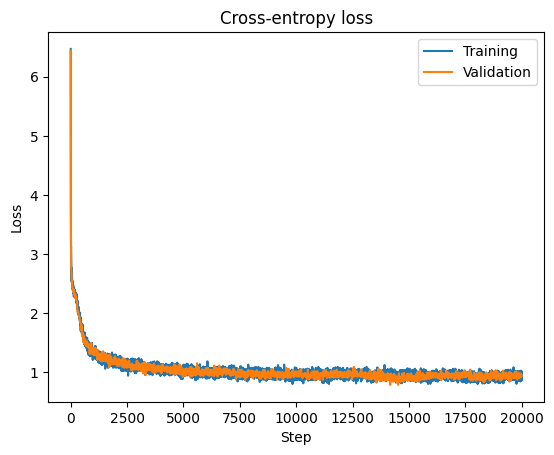

In [12]:
plt.plot(
    list(map(lambda x: x[0], training_losses)),
    list(map(lambda x: x[1], training_losses)),
    label="Training",
)
plt.plot(
    list(map(lambda x: x[0], validation_losses)),
    list(map(lambda x: x[1], validation_losses)),
    label="Validation",
)
plt.title("Cross-entropy loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Generating some text

Let's see what we got!

In [13]:
context = jnp.array(list("Once upon a time,".encode("utf-8")), dtype=int)
generated = jnp.array([], dtype=int)
cache = KVCache()

temperature = 0.1

for k in tqdm(range(200)):
    key, key_random = jax.random.split(key)

    input = generated[-1:] if generated.shape[0] > 0 else context
    logits, cache = model(input, cache)

    token = jax.random.categorical(key_random, logits[-1] / temperature)
    generated = jnp.concat([generated, token[None]])


100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


In [14]:
def decode(tokens):
    cpu_tokens = np.array(tokens.astype("uint8"))
    return bytes(cpu_tokens).decode("utf-8", errors="ignore")


print(decode(context) + decode(generated))

Once upon a time, LLL#eniiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii
